# Algoritmos Genéticos

## Representación

En los algoritmos genéticos la información de un individuo se codifica mediante una cadena binaria de longitud $L$

$$\color{blue}{I = B_1B_2B_3\cdots B_L}$$

Por ejemplo $I = 1001001$.

Supón que en el problema de optimización, la función de costo, $f(x)$, depende de una sola variable. Supón también que la variable está limitada a un rango de valores que va de $x_{min}$ hasta $x_{max}$. Podemos entonces asociar cada individuo con un valor de $x$ dentro del intervalo $[x_{min}, \;x_{max}]$ de la siguiente forma

$$\color{blue}{x(I) = x_{min}+D(I)\frac{x_{max}-x_{min}}{2^{N}-1}}$$

En donde $D(I)$ es el valor en base diez del número en base binaria definido en la cadena del individuo.

Por ejemplo, supón que se utiliza una cadena de dos bits para representar a los individuos y que la variable está acotada al intervalo $[1,\; 2]$. Los cuatro posibles individuos son los siguientes:

\begin{align}
    I_1 &= 00\\
    I_2 &= 01\\
    I_3 &= 10\\
    I_4 &= 11\\
\end{align}

Los valores en base diez de cada uno son 

\begin{align}
    D(I_1) &= 0\\
    D(I_2) &= 1\\
    D(I_3) &= 2\\
    D(I_4) &= 3\\
\end{align}

y cada uno de ellos se mapearía a los siguientes valores reales

\begin{align}
    x(I_1) &= 1+0\frac{1}{2^2-1} = 1\\
    x(I_2) &= 1+1\frac{1}{2^2-1} = 1\frac{1}{3}\\
    x(I_3) &= 1+2\frac{1}{2^2-1} = 1\frac{2}{3}\\
    x(I_2) &= 1+3\frac{1}{2^2-1} = 2\\
\end{align}

### Problemas multivariados

Si la función de costo depende de más de una variable, entonces para cada variable se define una cadena binaria de longitud adecuada y éstas se concatenan para formar al individuo completo. Por ejemplo, supón que la función de costo depende de dos variables y  que se utilizan tres bits para representar a cada uno de ellos, el individuo $I = 010110$ tiene asociadas las subcadenas $s_1 = 010$ y $s_2=110$ con cada una de las variables. 





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, sample, randint
#%matplotlib inline

## Población inicial 

Una vez que se define la representación de cada individuo se debe iniciar la <em>población</em>. Dicha población es un simple conjunto de individuos generados de forma aleatoria. Supongamos por ejemplo que el problema de optimización es tal que la función de costo depende de dos variables. Supón también que hemos decidido utilizar 4 bits para codificar cada variable y que la población quedará definida por 10 individuos.  

La siguiente función permite iniciar a dicha población

In [ ]:
def IniciaPob(N,n_var,n_bits):
    Pob = []
    for i in range(N):
        I = ''
        for v in range(n_var):
            for b in range(n_bits):
                I = I+sample(['0','1'],1)[0]
        Pob.append(I)
    return Pob

A cada individuo le corresponde una ubicación en el espacio bidimensional, pero para graficarlo es necesario tener una función que brinde los valores reales de las variables asociadas con cada individuo

In [ ]:
def Ind2Number(I, v_min, v_max, n_vars, n_bits):        
    numb = []
    for i in range(n_vars):
        cod_v = I[i*n_bits:(i+1)*n_bits]
        d_i = int(cod_v,2)
        val = v_min[i]+d_i*(v_max[i]-v_min[i])/float(2**n_bits-1)
        numb.append(val)
    return numb        

In [ ]:
def GraficaPoblacion(P):
    #Gráficas de curvas de nivel
    plt.clf()
    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')
    X = np.linspace(-5,5,100)
    Y = np.linspace(-5,5,100)
    X, Y = np.meshgrid(X, Y)
    Z = 20+X**2+Y**2-10*np.cos(2*np.pi*X)-10*np.cos(2*np.pi*Y)
    CS = plt.contour(X, Y, Z,alpha=0.75)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.title('Poblacion')

    #grafica la población
    for I in P:
        [x1,x2] = Ind2Number(I,v_min,v_max,n_var,n_bits)
        plt.scatter(x1,x2,s=30,c='r')    
    plt.show()
    
def GraficaPoblaciones(Ps):
    #Gráficas de curvas de nivel
    plt.clf()
    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')
    X = np.linspace(-5,5,100)
    Y = np.linspace(-5,5,100)
    X, Y = np.meshgrid(X, Y)
    Z = 20+X**2+Y**2-10*np.cos(2*np.pi*X)-10*np.cos(2*np.pi*Y)
    CS = plt.contour(X, Y, Z,alpha=0.75)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.title('Poblacion')

    #grafica la población
    cols = ['r','b','g','k']
    for i,P in enumerate(Ps):
        for I in P:
            [x1,x2] = Ind2Number(I,v_min,v_max,n_var,n_bits)
            plt.scatter(x1,x2,s=30,c=cols[i%4])    
    plt.show()

## Función de Aptitud

A cada individuo se le asocia un valor de aptitud que refleja la calidad del individuo como solución del problema. **Para los problemas de optimización la función de aptitud debe ser inversamente proporcional a la función de costo.** 

Por ejemplo, supongamos que buscamos optimizar la función de Rastrigin en dos variables. Para este caso, la función de costo es $f(x_1,x_2) = 20+x_1^2+x_2^2-10\cos{(2\pi x_1)}-10\cos{2\pi x_2}$. Una posibilidad para la función de aptitud es

$$A(x_1,x_2) = \frac{1}{1+\alpha f(x_1,x_2)}$$

Siendo $\alpha$ un parámetro que permite calibrar dicha función.

In [ ]:
#función de Rastrigin
def AptitudeRastringin(I):
    [x1,x2] = Ind2Number(I,v_min,v_max,n_var,n_bits)
    r = 20+x1**2+x2**2-10*np.cos(2*np.pi*x1)-10*np.cos(2*np.pi*x2)
    return 1.0/(1.0+0.1*r)    

In [ ]:
#función de Schwefel
def AptitudeSchwefel(I):
    [x1,x2] = Ind2Number(I,v_min,v_max,n_var,n_bits)
    r = (418.9829 * 2 - (x1 * (np.sin(np.sqrt(np.abs(x1)))) + (x2 * np.sin(np.sqrt(np.abs(x2))))))
    return 1.0/(1.0+0.1*r)    

In [ ]:
#función de Ackley
def AptitudeAckley(I):
    [x1,x2] = Ind2Number(I,v_min,v_max,n_var,n_bits)
    r = -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x1**2 + x2**2))) - np.exp(0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2))) + np.e + 20
    return 1.0/(1.0+0.1*r)

In [ ]:
#función de Langermann
def AptitudeLangermann(I):
    [x1,x2] = Ind2Number(I,v_min,v_max,n_var,n_bits)
    return 1.0/(1.0+0.1*r)

In [ ]:
def FunctionSelector(I,num):
  if num==1: #función de Rastrigin
    [x1,x2] = Ind2Number(I,v_min,v_max,n_var,n_bits)
    r = 20+x1**2+x2**2-10*np.cos(2*np.pi*x1)-10*np.cos(2*np.pi*x2)
    return 1.0/(1.0+0.1*r)   

  elif num == 2: #función de Schwefel
    [x1,x2] = Ind2Number(I,v_min,v_max,n_var,n_bits)
    r = (418.9829 * 2 - (x1 * (np.sin(np.sqrt(np.abs(x1)))) + (x2 * np.sin(np.sqrt(np.abs(x2))))))
    return 1.0/(1.0+0.1*r)    

  elif num == 3: #función de Ackley
    [x1,x2] = Ind2Number(I,v_min,v_max,n_var,n_bits)
    r = -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x1**2 + x2**2))) - np.exp(0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2))) + np.e + 20
    return 1.0/(1.0+0.1*r)

  elif num == 4: #función de Langermann
    [x1,x2] = Ind2Number(I,v_min,v_max,n_var,n_bits)
    return 1.0/(1.0+0.1*r)
  
  return False

In [ ]:
def Pop_Aptitude(P, num):
    apt_v = []
    for I in P:
        ap = FunctionSelector(I,num)
        #print 'Individuo ' + I + ', aptitud = '  + str(ap)
        apt_v.append(ap)
    return apt_v

## Operadores Genéticos

### Cruza

Por medio del operador genético de cruza es posible intercambiar la información contenida en dos individuos. Los individuos con los que se realizará la cruza deben ser seleccionados con una probabilidad proporcional a su aptitud.

Existen varias opciones para realizar la cruza una vez que se seleccionaron los individuos. Una de las más utilizadas es la cruza en un solo punto. En esta estrategia

1. Se selecciona aleatoriamente una posición sobre la cual se cortarán ambos individuos en dos subcadenas. La posición debe estar comprendida entre el segundo y el penúltimo índices.
2. El nuevo individuo se genera seleccionando la primera subcadena del primer individuo y concatenándola con la segunda subcadena del segundo individuo.

Por ejemplo, supón que los individos seleccionados para la cruza son los siguientes

\begin{align}
    I_1 &= \color{blue}{001}\color{red}{01101}\\
    I_2 &= \color{red}{010}\color{blue}{11010}
\end{align}

Supón que la posición seleccionada es la tercera. El nuevo individuo sería

$$I_n = \color{blue}{00111010}$$



In [ ]:
def CrossOver(I1,I2):
    n = len(I1)
    p = randint(1,n-2)
    b1 = I1[:p]
    b2 = I2[p:]
    return b1+b2

Cada vez que se aplica la cruza se genera un nuevo individuo y este proceso se debe repetir por cada uno de los individuos de la población original, con lo que se genera una nueva población

In [ ]:
#selecciona un individuo de la población de acuerdo a su aptitud
def select(P,Aptitude):
    apt_acum = sum(Aptitude)
    r = random()*apt_acum
    s = 0
    for i,I in enumerate(P):
        s = s+Aptitude[i]
        if s >= r:
            return I
    return I

In [ ]:
#probabilidad de cruza = 100%
def CrossOverPop(P,Aptitude):
    CrossP = []
    for I in P:
        I1 = select(P,Aptitude)
        I2 = select(P,Aptitude)
        nI = CrossOver(I1,I2)
        CrossP.append(nI)
    return CrossP        

### Mutación

En la mutación perturbamos con cierta probablidad la información genética contenida en un individuo. Para esto debemos recorrer cada bit del individuo y decidir si se cambia el valor de dicho bit en base a una probabilidad definida, llamada probabilidad de mutación: $p_m$. Por ejemplo, si $p_m = 0.01$, se debe cambiar aproximadamente el valor de uno de cada cien bits. 

In [ ]:
def Mutation(P,pm):
    PM = []
    cs = {'0':'1','1':'0'}
    for I in P:
        nI = ''
        for b in I:
            if random() < pm:
                nI = nI+cs[b]
            else:
                nI = nI+b
        PM.append(nI)
    return PM    

### Selección

A través de la selección elegimos entre varios individuos aquellos que tengan el mayor valor de aptitud. Por ejemplo, si se tienen dos poblaciones, entre una pareja de individuos elegidos aleatoriamente de cada población, se selecciona el que tenga la mayor aptitud para formar parte de la nueva población

In [ ]:
def SelectP(P1,P2,A1,A2):
    PS = []
    for i in range(len(P1)):
        if A1[i] > A2[i]:
            PS.append(P1[i])
        else:
            PS.append(P2[i])
    return PS

## Evolución

La evolución en los algoritmos genéticos se realiza aplicando sucesivamente los operadores de cruza, mutación y selección a una población. En cada aplicación se genera una nueva población. La esperanza es que la evolución permita construir una secuencia de poblaciones que converja hacia la solución del problema de optimización. El número de veces que se aplica la secuencia de operadores se denomina <em>generaciones</em>

In [ ]:
def Evolution(P0,pm,gnrtns):
    P = P0
    for g in range(gnrtns):
        AP = Pop_Aptitude(P, 1)
        PC = CrossOverPop(P,AP)
        PM = Mutation(PC,pm)
        AM = Pop_Aptitude(PM, 1)
        P = SelectP(P,PM,AP,AM)
    return P        

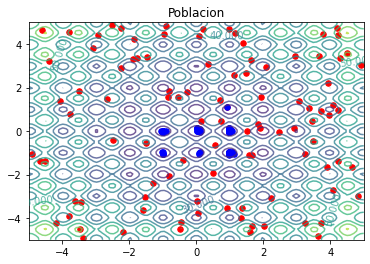

La mejor solución encontrada es: [0.024437927663734094, 0.024437927663734094], con una Aptitud de 0.9768962542524533


In [ ]:
N = 100
n_var = 2
n_bits = 10
P0 = IniciaPob(N,n_var,n_bits)
v_min = [-5,-5]
v_max = [5,5]
n_gens = 10
P = Evolution(P0,0.01,n_gens)
GraficaPoblaciones([P0,P])

#elegir como solución del problema el elemento de la población con la mayor aptitud
A = Pop_Aptitude(P, 1)
ind = np.argmax(A)
print("La mejor solución encontrada es: " + str(Ind2Number(P[ind],v_min, v_max, n_var, n_bits)) + ', con una Aptitud de ' + str(A[ind]))